In [1]:
# =========================
# 1️⃣ IMPORT LIBRARIES
# =========================
import pandas as pd
import numpy as np

# Models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

# Metrics & preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


In [2]:
import pandas as pd
import zipfile

# Unzip
with zipfile.ZipFile("optiver-trading-at-the-close.zip","r") as zip_ref:
    zip_ref.extractall("optiver_data")

# List files
import os
os.listdir("optiver_data")


['example_test_files',
 'optiver2023',
 'public_timeseries_testing_util.py',
 'train.csv']

In [3]:
train_df = pd.read_csv("./optiver_data/train.csv")

print(train_df.head())

   stock_id  date_id  seconds_in_bucket  imbalance_size  \
0         0        0                  0      3180602.69   
1         1        0                  0       166603.91   
2         2        0                  0       302879.87   
3         3        0                  0     11917682.27   
4         4        0                  0       447549.96   

   imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                        1         0.999812   13380276.64        NaN   
1                       -1         0.999896    1642214.25        NaN   
2                       -1         0.999561    1819368.03        NaN   
3                       -1         1.000171   18389745.62        NaN   
4                       -1         0.999532   17860614.95        NaN   

   near_price  bid_price  bid_size  ask_price   ask_size  wap    target  \
0         NaN   0.999812  60651.50   1.000026    8493.03  1.0 -3.029704   
1         NaN   0.999896   3233.04   1.000660   20605.09  1.0 

In [4]:
test_df = pd.read_csv("./optiver_data/example_test_files/test.csv")
print(test_df.head())

   stock_id  date_id  seconds_in_bucket  imbalance_size  \
0         0      478                  0      3753451.43   
1         1      478                  0       985977.11   
2         2      478                  0       599128.74   
3         3      478                  0      2872317.54   
4         4      478                  0       740059.14   

   imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                       -1         0.999875   11548975.43        NaN   
1                       -1         1.000245    3850033.97        NaN   
2                        1         1.000584    4359198.25        NaN   
3                       -1         0.999802   27129551.64        NaN   
4                       -1         0.999886    8880890.78        NaN   

   near_price  bid_price  bid_size  ask_price  ask_size  wap  time_id  \
0         NaN   0.999875  22940.00   1.000050   9177.60  1.0    26290   
1         NaN   0.999940   1967.90   1.000601  19692.00  1.0    26

In [5]:
# =========================
# 2️⃣ FEATURE ENGINEERING
# =========================

# Example simple features
train_df['bid_ask_spread'] = train_df['ask_price'] - train_df['bid_price']
train_df['imbalance_signed'] = train_df['imbalance_size'] * train_df['imbalance_buy_sell_flag']


In [6]:
# Lagged features (simple 1-step lag per stock)
train_df = train_df.sort_values(['stock_id','seconds_in_bucket'])
train_df['wap_lag1'] = train_df.groupby('stock_id')['wap'].shift(1)
train_df['target_lag1'] = train_df.groupby('stock_id')['target'].shift(1)

# Drop NaNs created by lag
train_df = train_df.dropna()

# Features & target
features = [
    'reference_price', 'far_price', 'near_price', 'bid_price', 'ask_price',
    'bid_size', 'ask_size', 'wap', 'bid_ask_spread', 'imbalance_signed',
    'wap_lag1', 'target_lag1'
]
target = 'target'


In [7]:
# =========================
# 3️⃣ TRAIN / VALID SPLIT
# =========================

# Split by time or date_id is better than random
X = train_df[features]
y = train_df[target]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)


In [8]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

lgb_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_valid]
    #early_stopping_rounds=50
)

y_pred_lgb = lgb_model.predict(X_valid)
print("LightGBM RMSE:", mean_squared_error(y_valid, y_pred_lgb))


LightGBM RMSE: 60.070183892250306


### Xgboost

In [9]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='rmse',
    early_stopping_rounds=50
)

xgb_model.fit(X_train, y_train, 
              eval_set=[(X_valid, y_valid)], 
              verbose=50)

y_pred_xgb = xgb_model.predict(X_valid)
print("XGBoost RMSE:", mean_squared_error(y_valid, y_pred_xgb))


[0]	validation_0-rmse:7.82502
[50]	validation_0-rmse:7.74706
[100]	validation_0-rmse:7.73918
[150]	validation_0-rmse:7.73772
[200]	validation_0-rmse:7.73718
[250]	validation_0-rmse:7.73760
[255]	validation_0-rmse:7.73771
XGBoost RMSE: 59.858118530335325


### CatBoost

In [10]:
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='RMSE',
    early_stopping_rounds=50,
    verbose=50
)

# CatBoost can handle categorical features natively
categorical_features = []  # e.g., ['stock_id'] if desired

cat_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=categorical_features)

y_pred_cat = cat_model.predict(X_valid)
print("CatBoost RMSE:", mean_squared_error(y_valid, y_pred_cat))


0:	learn: 8.4997774	test: 7.8265207	best: 7.8265207 (0)	total: 175ms	remaining: 2m 55s
50:	learn: 8.3922209	test: 7.7578299	best: 7.7578299 (50)	total: 2.6s	remaining: 48.3s
100:	learn: 8.3642248	test: 7.7468654	best: 7.7468654 (100)	total: 5.02s	remaining: 44.7s
150:	learn: 8.3451541	test: 7.7424856	best: 7.7424856 (150)	total: 7.44s	remaining: 41.8s
200:	learn: 8.3310090	test: 7.7403892	best: 7.7403892 (200)	total: 9.76s	remaining: 38.8s
250:	learn: 8.3186892	test: 7.7389312	best: 7.7389312 (250)	total: 12.2s	remaining: 36.5s
300:	learn: 8.3065533	test: 7.7378503	best: 7.7378452 (291)	total: 15s	remaining: 34.8s
350:	learn: 8.2966488	test: 7.7376540	best: 7.7376540 (350)	total: 17.5s	remaining: 32.3s
400:	learn: 8.2874005	test: 7.7376696	best: 7.7374803 (396)	total: 19.9s	remaining: 29.7s
450:	learn: 8.2787000	test: 7.7378063	best: 7.7373700 (428)	total: 22.5s	remaining: 27.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 7.737369997
bestIteration = 428

Shrink mo

### XGBoost and Agg Features (9)

In [11]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data into cuDF DataFrame for GPU processing
train_df = pd.read_csv('./optiver_data/train.csv')
train_df.head()


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [12]:

train_df = train_df.sort_values(['stock_id', 'date_id'])

In [13]:
train_df['wap_lag1'] = train_df.groupby('stock_id')['wap'].shift(1)
train_df['reference_price_lag1'] = train_df.groupby('stock_id')['reference_price'].shift(1)
train_df['far_lag1'] = train_df.groupby('stock_id')['far_price'].shift(1)
train_df['near_lag1'] = train_df.groupby('stock_id')['near_price'].shift(1)

In [14]:
train_df['far_diff'] = train_df['far_price'] - train_df['reference_price']
train_df['near_diff'] = train_df['near_price'] - train_df['reference_price']
train_df['bid_ask_spread'] = train_df['ask_price'] - train_df['bid_price']
train_df['wap_ref_diff'] = train_df['wap'] - train_df['reference_price']


In [15]:
train_df['imbalance_signed'] = train_df['imbalance_size'] * train_df['imbalance_buy_sell_flag']
train_df['imbalance_ratio'] = train_df['imbalance_size'] / (train_df['matched_size'] + 1e-6)  # avoid divide by zero

In [16]:
train_df['bid_ask_ratio'] = train_df['bid_size'] / (train_df['ask_size'] + 1e-6)
train_df['bid_ask_diff'] = train_df['bid_size'] - train_df['ask_size']
train_df['total_liquidity'] = train_df['bid_size'] + train_df['ask_size']


In [17]:
# Rolling mean/std for each stock
train_df['wap_rolling_mean3'] = train_df.groupby('stock_id')['wap'].transform(lambda x: x.rolling(3).mean())
train_df['wap_rolling_std3'] = train_df.groupby('stock_id')['wap'].transform(lambda x: x.rolling(3).std())

train_df['reference_rolling_mean3'] = train_df.groupby('stock_id')['reference_price'].transform(lambda x: x.rolling(3).mean())


In [18]:
train_df.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id', 'wap_lag1',
       'reference_price_lag1', 'far_lag1', 'near_lag1', 'far_diff',
       'near_diff', 'bid_ask_spread', 'wap_ref_diff', 'imbalance_signed',
       'imbalance_ratio', 'bid_ask_ratio', 'bid_ask_diff', 'total_liquidity',
       'wap_rolling_mean3', 'wap_rolling_std3', 'reference_rolling_mean3'],
      dtype='object')

In [19]:
train_df = train_df.dropna()  # remove rows with missing lag/rolling features

features = [
    'stock_id', 'date_id', 'wap_lag1','reference_price_lag1','far_lag1','near_lag1',
    'far_diff','near_diff','bid_ask_spread','wap_ref_diff',
    'imbalance_signed','imbalance_ratio',
    'bid_ask_ratio','bid_ask_diff','total_liquidity',
    'wap_rolling_mean3','wap_rolling_std3','reference_rolling_mean3',
]

train_df = train_df.sort_values("date_id")

X = train_df[features]
y = train_df['target']


In [20]:
# split_index = int(len(train_df) * 0.8)
# X_train, X_valid = X.iloc[:split_index], X.iloc[split_index:]
# y_train, y_valid = y.iloc[:split_index], y.iloc[split_index:]

unique_dates = train_df["date_id"].unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
valid_dates = unique_dates[split_index:]

X_train = X[X["date_id"].isin(train_dates)]
y_train = y[X["date_id"].isin(train_dates)]

X_valid = X[X["date_id"].isin(valid_dates)]
y_valid = y[X["date_id"].isin(valid_dates)]


In [21]:
X_train.tail()

,stock_id,date_id,wap_lag1,reference_price_lag1,far_lag1,near_lag1,far_diff,near_diff,bid_ask_spread,wap_ref_diff,imbalance_signed,imbalance_ratio,bid_ask_ratio,bid_ask_diff,total_liquidity,wap_rolling_mean3,wap_rolling_std3,reference_rolling_mean3
4170706,126,383,1.000633,1.000615,1.001284,1.001284,0.000669,0.000669,0.000168,-0.000034,4961658.81,0.073692,4.006137,264121.91,439843.69,1.000584,0.000048,1.000587
4170906,126,383,1.000581,1.000615,1.001284,1.001284,0.000335,0.000335,0.000167,-0.000032,4412701.18,0.065449,4.199298,57424.20,93322.20,1.000710,0.000181,1.000726
4169545,165,383,1.003664,1.003848,1.004951,1.003848,0.001103,0.000000,0.000552,-0.000193,1351410.39,0.119502,1.857565,145056.13,483353.75,1.003441,0.000379,1.003664
4170145,165,383,1.003605,1.003848,1.003848,1.003848,0.000000,0.000000,0.000552,-0.000196,1099230.47,0.094181,1.817030,141617.81,488282.83,1.003620,0.000028,1.003848
4168562,182,383,1.000495,1.000461,0.999846,1.000256,-0.000615,-0.000205,0.000205,0.000047,-301129.37,0.023692,0.297722,-146942.23,271530.87,1.000505,0.000009,1.000461


In [22]:
X_valid.head()

,stock_id,date_id,wap_lag1,reference_price_lag1,far_lag1,near_lag1,far_diff,near_diff,bid_ask_spread,wap_ref_diff,imbalance_signed,imbalance_ratio,bid_ask_ratio,bid_ask_diff,total_liquidity,wap_rolling_mean3,wap_rolling_std3,reference_rolling_mean3
4179743,163,384,0.999296,0.999354,0.99724,0.998168,-0.002153,-0.001225,0.000375,0.000050,-3143617.79,0.023252,0.999624,-19.00,101171.00,0.999337,0.000093,0.999308
4179543,163,384,0.999271,0.999176,0.99724,0.998168,-0.002114,-0.001186,0.000198,-0.000058,-3280274.82,0.024287,0.444357,-17707.55,46029.55,0.999363,0.000138,0.999314
4179343,163,384,0.999521,0.999413,0.99724,0.998168,-0.001936,-0.001008,0.000177,0.000095,-3141087.11,0.023257,6.665480,17192.92,23262.28,0.999445,0.000151,0.999354
4179143,163,384,0.999543,0.999472,0.99724,0.998168,-0.002173,-0.001245,0.000257,0.000108,-3280274.82,0.024287,1.349304,25272.41,169974.11,0.999532,0.000011,0.999426
4178943,163,384,0.999531,0.999393,0.99724,0.998168,-0.002232,-0.001304,0.000237,0.000071,-3305075.54,0.024471,2.499407,30344.40,70819.60,0.999569,0.000056,0.999459


In [24]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np


In [25]:
# Time-aware cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define the XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',  # or 'gpu_hist' if GPU available
    random_state=42
)

# Hyperparameter grid
param_grid = {
    "n_estimators": [100, 500, 1000, 1500],
    "max_depth": [3, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 1, 5],
    "reg_alpha": [0, 0.01, 0.1],
    "reg_lambda": [1, 1.5, 2],
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=5,                # number of random combinations to try
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [26]:
# Fit on the full dataset
random_search.fit(X, y)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.8, ...], 'gamma': [0, 1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 6, ...], ...}"
,n_iter,5
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [27]:
# # Best parameters
# print("Best parameters found:", random_search.best_params_)
# print("Best RMSE (negative):", random_search.best_score_)

# # Train final model with best params
# best_model = random_search.best_estimator_

from sklearn.metrics import mean_squared_error
import numpy as np

neg_rmse = random_search.best_score_
rmse = -neg_rmse  # now positive
print(f"Best RMSE: {rmse:.5f}")


Best RMSE: 8.34850


### XGBoost and LightGBM

In [28]:
import xgboost as xgb
import lightgbm as lgb
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

# Assume X_train, X_valid, y_train, y_valid are ready

# Base models
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    random_state=42
)

lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train base models
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,6
,learning_rate,0.05
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [29]:

# Generate predictions for the meta-model
xgb_pred_train = xgb_model.predict(X_train).reshape(-1, 1)
lgb_pred_train = lgb_model.predict(X_train).reshape(-1, 1)
meta_X_train = np.hstack([xgb_pred_train, lgb_pred_train])

xgb_pred_valid = xgb_model.predict(X_valid).reshape(-1, 1)
lgb_pred_valid = lgb_model.predict(X_valid).reshape(-1, 1)
meta_X_valid = np.hstack([xgb_pred_valid, lgb_pred_valid])


In [30]:

# Meta-model (simple linear regression)
meta_model = LinearRegression()
meta_model.fit(meta_X_train, y_train)

# Final predictions
y_pred_hybrid = meta_model.predict(meta_X_valid)


In [31]:
from sklearn.metrics import mean_squared_error
import numpy as np

# y_valid: true values
# y_pred_hybrid: predictions from your hybrid model

rmse = np.sqrt(mean_squared_error(y_valid, y_pred_hybrid))
print(f"Validation RMSE: {rmse:.5f}")


Validation RMSE: 7.55227


In [32]:
# Get predictions from each base model
xgb_pred = xgb_model.predict(X_valid)
lgb_pred = lgb_model.predict(X_valid)

# Define blending weights
w_xgb = 0.6
w_lgb = 0.4

# Compute blended predictions
y_pred_blend = w_xgb * xgb_pred + w_lgb * lgb_pred

# Evaluate RMSE
rmse_blend = np.sqrt(mean_squared_error(y_valid, y_pred_blend))
print(f"Blended model RMSE: {rmse_blend:.5f}")

Blended model RMSE: 7.51568


In [33]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # regression task
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',  # fast GPU-based tree building
    random_state=42
)

In [34]:
from xgboost import XGBRegressor, callback

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    #early_stopping_rounds=50,
    #callback=[callback.EarlyStopping(rounds=50, save_best=True, data_name="validation")],
    # callbacks=[
    #     callback.EarlyStopping(rounds=10, min_delta=1e-3),
    #     callback.EvaluationMonitor(period=1, show_stdv=True)
    # ],
    # verbose=50
)


[0]	validation_0-rmse:7.59426
[1]	validation_0-rmse:7.58874
[2]	validation_0-rmse:7.58338
[3]	validation_0-rmse:7.57889
[4]	validation_0-rmse:7.57489
[5]	validation_0-rmse:7.57232
[6]	validation_0-rmse:7.56845
[7]	validation_0-rmse:7.56510
[8]	validation_0-rmse:7.56159
[9]	validation_0-rmse:7.55947
[10]	validation_0-rmse:7.55686
[11]	validation_0-rmse:7.55429
[12]	validation_0-rmse:7.55219
[13]	validation_0-rmse:7.54992
[14]	validation_0-rmse:7.54812
[15]	validation_0-rmse:7.54581
[16]	validation_0-rmse:7.54377
[17]	validation_0-rmse:7.54198
[18]	validation_0-rmse:7.54105
[19]	validation_0-rmse:7.53920
[20]	validation_0-rmse:7.53790
[21]	validation_0-rmse:7.53711
[22]	validation_0-rmse:7.53555
[23]	validation_0-rmse:7.53464
[24]	validation_0-rmse:7.53363
[25]	validation_0-rmse:7.53266
[26]	validation_0-rmse:7.53146
[27]	validation_0-rmse:7.53033
[28]	validation_0-rmse:7.52976
[29]	validation_0-rmse:7.52889
[30]	validation_0-rmse:7.52777
[31]	validation_0-rmse:7.52730
[32]	validation_0-

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [35]:
y_pred = xgb_model.predict(X_valid)


In [36]:
import numpy as np
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f'Validation RMSE: {rmse:.4f}')

Validation RMSE: 7.5178


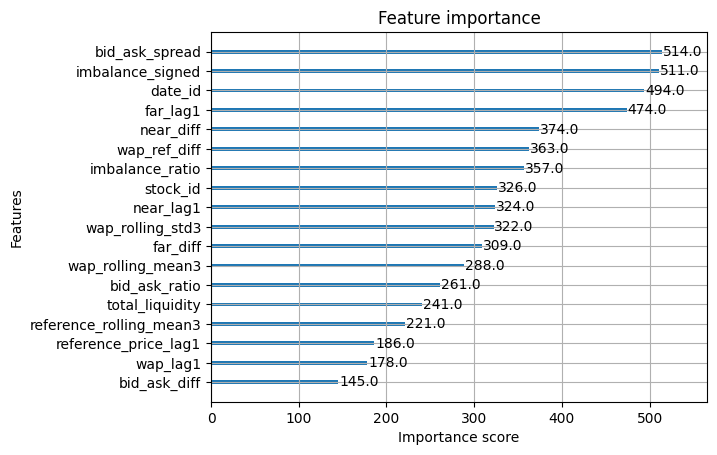

In [37]:
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_model, max_num_features=20)
plt.show()


### GRU XGBoost

In [38]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import xgboost as xgb
import numpy as np
import pandas as pd

# -----------------------------
# 1. Prepare sequential dataset
# -----------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, df, features, target, seq_len=5):
        self.features = features
        self.target = target
        self.seq_len = seq_len
        self.data = []

        # Group by stock
        for stock_id, group in df.groupby("stock_id"):
            group = group.sort_values("date_id")
            X = group[features].values
            y = group[target].values
            for i in range(len(group) - seq_len):
                self.data.append((X[i:i+seq_len], y[i+seq_len]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq_x, seq_y = self.data[idx]
        return torch.tensor(seq_x, dtype=torch.float32), torch.tensor(seq_y, dtype=torch.float32)

seq_len = 5
train_dataset = TimeSeriesDataset(train_df[train_df["date_id"].isin(train_dates)], features, 'target', seq_len)
valid_dataset = TimeSeriesDataset(train_df[train_df["date_id"].isin(valid_dates)], features, 'target', seq_len)


In [39]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)


In [40]:
# 2. Build GRU model
# -----------------------------
class GRURegressor(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super(GRURegressor, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.hidden_size = hidden_size

    def forward(self, x):
        out, h = self.gru(x)          # out: [batch, seq_len, hidden_size]
        last_hidden = out[:, -1, :]   # take last timestep
        pred = self.fc(last_hidden)   # pred: [batch, 1]
        return pred, last_hidden      # prediction, GRU features


input_size = len(features)
gru_model = GRURegressor(input_size=input_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.001)

In [41]:
# -----------------------------
# 3. Train GRU
# -----------------------------
epochs = 5  # increase for real training
gru_model.train()
for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred, _ = gru_model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 1/5, Loss: 51.6400
Epoch 2/5, Loss: 42.1642
Epoch 3/5, Loss: 104.4561
Epoch 4/5, Loss: 82.2023
Epoch 5/5, Loss: 34.8122


In [42]:
# -----------------------------
# 4. Generate GRU features for XGBoost
# -----------------------------
def generate_gru_features(model, dataset):
    model.eval()
    features_list = []
    targets = []
    with torch.no_grad():
        for X_batch, y_batch in DataLoader(dataset, batch_size=64):
            _, gru_feat = model(X_batch)
            features_list.append(gru_feat.numpy())
            targets.append(y_batch.numpy())
    return np.vstack(features_list), np.hstack(targets)

X_train_gru, y_train_gru = generate_gru_features(gru_model, train_dataset)
X_valid_gru, y_valid_gru = generate_gru_features(gru_model, valid_dataset)

In [43]:
# Combine GRU features with original features (last timestep only)
def combine_features(dataset, gru_features, features):
    combined = []
    for i, (X_seq, _) in enumerate(dataset):
        last_timestep_features = X_seq[-1].numpy()
        combined.append(np.concatenate([last_timestep_features, gru_features[i]]))
    return np.vstack(combined)

X_train_combined = combine_features(train_dataset, X_train_gru, features)
X_valid_combined = combine_features(valid_dataset, X_valid_gru, features)

In [44]:
# -----------------------------
# 5. Train XGBoost on combined features
# -----------------------------
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    random_state=42
)

xgb_model.fit(X_train_combined, y_train_gru)
preds = xgb_model.predict(X_valid_combined)

In [45]:
from sklearn.metrics import mean_squared_error
print("Validation RMSE:", np.sqrt(mean_squared_error(y_valid_gru, preds)))

Validation RMSE: 7.599335551077548
